In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph, makeXforGraphWithGroupingSeason, train_2d_sigma_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

paju_wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addPajuWt = ADD_data_loader(paju_wt_fileList)
print("Paju winter data:",addPajuWt.shape)
print("")
addPajuSp = ADD_data_loader(paju_sp_fileList)
print("Paju spring data:",addPajuSp.shape)
print("")
addPajuSm = ADD_data_loader(paju_sm_fileList)
print("Paju summer data:",addPajuSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addPajuWt, addPajuSp, addPajuSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(22518, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(22505, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(22532, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 114    m      1.01    113.75      0.02       0       1399        30       15        2
     115    m      1.01    123.75      0.02       0       1399        30       15        2
     116    m      1.01    114.46      0.02       0       1399        30       15        2
     117    m      1.01    111.13      0.02       0       1399        30       15        2
     118    m      1.00    100.27      0.02       0       1399        30       15        2
Combine

data distribution(before)
       logFrequency    season  pathloss
count     123134.00 123134.00 123134.00
mean           3.04      0.54    127.74
std            0.31      0.45     14.12
min            2.60      0.00     85.47
25%            2.60      0.00    117.05
50%            3.15      0.50    128.39
75%            3.35      1.00    138.74
max            3.35      1.00    171.41
sampling shape(before):(123134, 3)
sampling shape(after):(1231, 3)
data distribution(after)
       logFrequency  season  pathloss
count       1231.00 1231.00   1231.00
mean           3.04    0.53    127.83
std            0.31    0.45     13.86
min            2.60    0.00     85.72
25%            2.60    0.00    117.67
50%            3.15    0.50    128.86
75%            3.35    1.00    138.62
max            3.35    1.00    165.86
normalization distribution(before):
       logFrequency  season  pathloss
count       1231.00 1231.00   1231.00
mean           3.04    0.53    127.83
std            0.31    0.45   

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


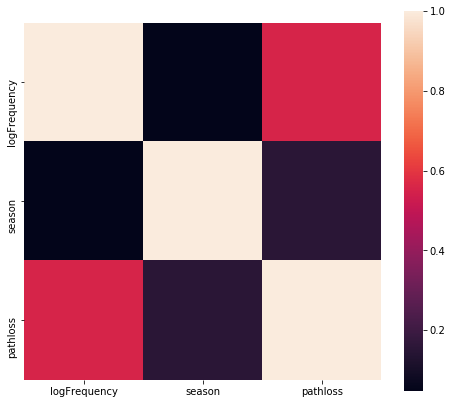

In [3]:
%autoreload

targetCols = ['logFrequency', 'season', 'pathloss']
xCols = ['logFrequency', 'season',]
yCols = 'pathloss'

samplingRatio = 0.01
addData = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

sc = 'manual'

addDataNorm, normalizer = normalizeData(addData[targetCols], addData[yCols], scaler = sc)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addData[yCols])

In [4]:
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'ESS'
model = gp_regression(kernel)

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model.fit(X_train, y_train)
#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train, std_train = model.predict(X_train, return_std=True)
    pred_test, std_test = model.predict(X_test, return_std=True)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    print("GP-Error(RMSE)"+str(i)+" train: {} / test: {}".format(trainError, testError))

    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])

    filename = 'model/gp_'+kernel+'_'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))    
    i+=1
i-=1

GP-Error(RMSE)1 train: 11.605313920559858 / test: 11.525119552855061
GP-Error(RMSE)2 train: 11.730977807638164 / test: 11.098309551207114
GP-Error(RMSE)3 train: 11.518763993601949 / test: 11.746499431869353
GP-Error(RMSE)4 train: 11.497209864266493 / test: 12.005091825320513
GP-Error(RMSE)5 train: 11.572284833941133 / test: 11.743518714920281


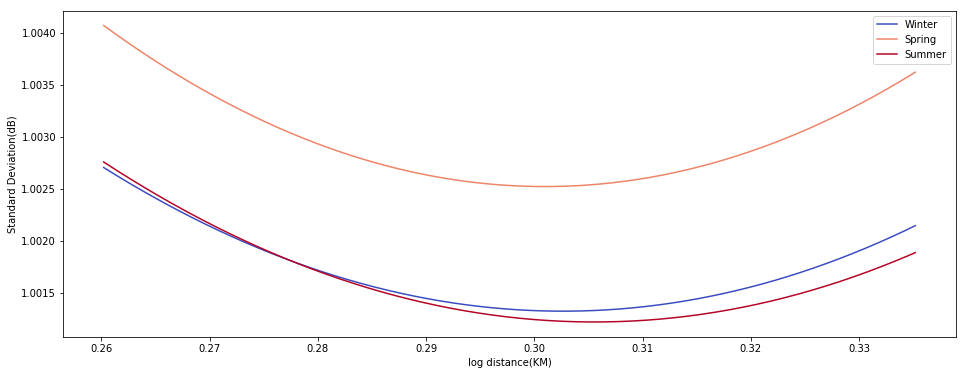

In [6]:
%autoreload
kernel = "ESS"
i = 5
model = pickle.load(open('model/gp_'+kernel+'_'+str(i)+'.sav', 'rb'))

X = dataSet[4][0]
Y = dataSet[4][1]

data = makeXforGraphWithGroupingSeason(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=[yCols]))

graphX = data[0]
graphY = data[1]
train_2d_sigma_graph(model, graphX, graphY, 'logFrequency')

In [7]:
pred, sigma = model.predict(X, return_std=True) 

%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0

linearModel = Ridge(alpha=0.0001)
model = pickle.load(open('model/gp_'+kernel+'_'+str(i)+'.sav', 'rb'))

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("-"*100)
#     X_train = scaler.inverse_transform(X_train)
#     X_test = scaler.inverse_transform(X_test)
    print("Equation Derivation for trainset #{}".format(i))

    pred, sigma = model.predict(X_train, return_std=True)
    
    linearModel.fit(X_train, sigma)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    RMSE_LIN_MODEL = np.sqrt(mean_squared_error(sigma, linearPredTrain))

    print("Linear-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(RMSE_LIN_TRAIN,RMSE_LIN_TEST))
    print("GP-Linear-Error(RMSE):", RMSE_LIN_MODEL)    

    print("\nObjective Function")
    print("STD = {:6.2f}log_f + {:6.2f}s + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[1],linearModel.intercept_)) 
    i+=1

----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1
Linear-Error(RMSE)-1-train:127.87/test:126.44
GP-Linear-Error(RMSE): 0.0007374458595581584

Objective Function
STD =  -0.02log_f +  -0.00s +   1.01
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #2
Linear-Error(RMSE)-2-train:127.58/test:127.62
GP-Linear-Error(RMSE): 0.0007440460290233048

Objective Function
STD =  -0.02log_f +  -0.00s +   1.01
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #3
Linear-Error(RMSE)-3-train:127.60/test:127.53
GP-Linear-Error(RMSE): 0.0007316022479305319

Objective Function
STD =  -0.02log_f +  -0.00s +   1.01
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #4
Linear-E

In [8]:
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'
model = gp_regression(kernel)

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model.fit(X_train, y_train)
#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train, std_train = model.predict(X_train, return_std=True)
    pred_test, std_test = model.predict(X_test, return_std=True)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    print("GP-Error(RMSE)"+str(i)+" train: {} / test: {}".format(trainError, testError))

    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])

    filename = 'model/gp_'+kernel+'_'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))    
    i+=1
i-=1

GP-Error(RMSE)1 train: 11.143625604463118 / test: 11.888763538039871
GP-Error(RMSE)2 train: 11.317713734943867 / test: 11.210885830503244
GP-Error(RMSE)3 train: 11.19164048738713 / test: 11.689678314130632
GP-Error(RMSE)4 train: 11.348747902918591 / test: 10.995565116548072
GP-Error(RMSE)5 train: 11.313619073604293 / test: 11.248181881392064


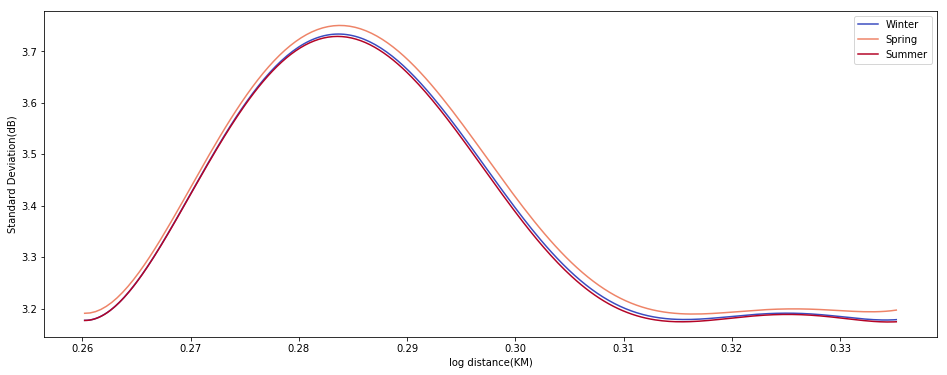

In [10]:
%autoreload
kernel = "RBF"
i = 5
model = pickle.load(open('model/gp_'+kernel+'_'+str(i)+'.sav', 'rb'))

X = dataSet[4][0]
Y = dataSet[4][1]

data = makeXforGraphWithGroupingSeason(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=[yCols]))

graphX = data[0]
graphY = data[1]
train_2d_sigma_graph(model, graphX, graphY, 'logFrequency')

In [12]:
pred, sigma = model.predict(X, return_std=True) 

%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0

linearModel = Ridge(alpha=0.0001)
model = pickle.load(open('model/gp_'+kernel+'_'+str(i)+'.sav', 'rb'))

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("-"*100)
#     X_train = scaler.inverse_transform(X_train)
#     X_test = scaler.inverse_transform(X_test)
    print("Equation Derivation for trainset #{}".format(i))

    pred, sigma = model.predict(X_train, return_std=True)
    
    linearModel.fit(X_train, sigma)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    RMSE_LIN_MODEL = np.sqrt(mean_squared_error(sigma, linearPredTrain))

    print("Linear-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(RMSE_LIN_TRAIN,RMSE_LIN_TEST))
    print("GP-Linear-Error(RMSE):", RMSE_LIN_MODEL)    

    print("\nObjective Function")
    print("STD = {:6.2f}log_f + {:6.2f}s + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[1],linearModel.intercept_)) 
    i+=1

----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1
Linear-Error(RMSE)-1-train:125.28/test:125.70
GP-Linear-Error(RMSE): 0.006124810016878471

Objective Function
STD =  -0.01log_f +  -0.00s +   3.18
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #2
Linear-Error(RMSE)-2-train:125.29/test:125.67
GP-Linear-Error(RMSE): 0.006096417120224428

Objective Function
STD =  -0.01log_f +  -0.00s +   3.18
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #3
Linear-Error(RMSE)-3-train:125.47/test:124.95
GP-Linear-Error(RMSE): 0.006244116648371302

Objective Function
STD =  -0.00log_f +  -0.00s +   3.18
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #4
Linear-Erro